# Inference testing

## Module load

In [1]:
using Pkg
Pkg.activate("..")

  Activating project at `~/julia_codes/SmallCouplingDynamicCavity`


In [2]:
using SmallCouplingDynamicCavity
using Plots, LaTeXStrings
using Graphs, GraphRecipes
using Distributions

[ Info: Precompiling SmallCouplingDynamicCavity [1607259e-80f4-4675-b495-cb9c54bacb3f]
  ** incremental compilation may be fatally broken for this module **



In [3]:
function sort_by_infection_time(X, T, NV)
    inf_tuples = Dict()
    first_time_inf = ones(Int, NV).*(T+1)
    for i=1:NV
        t1 = 0
        t2 = 0
        inf = false
        for t=0:T
            if X[i,t+1]==1.0 && !inf
                t1 = t
                inf = true
            elseif X[i,t+1]==2.0 && inf
                t2 = t
                if !haskey(inf_tuples, i)
                    merge!(inf_tuples, Dict(i=>[(t1,t2)]))
                    first_time_inf[i] = t1
                else
                    push!(inf_tuples[i],(t1,t2))
                end
                inf = false
            else
                continue
            end
        end
        if inf
            if !haskey(inf_tuples, i)
                merge!(inf_tuples, Dict(i=>[(t1,T)]))
                first_time_inf[i] = t1
            else
                push!(inf_tuples[i],(t1,T))
            end
        end
    end
    #display(first_time_inf)
    perm = sortperm(first_time_inf)
    
    return inf_tuples, invperm(perm), perm
end

sort_by_infection_time (generic function with 1 method)

## Graph generation

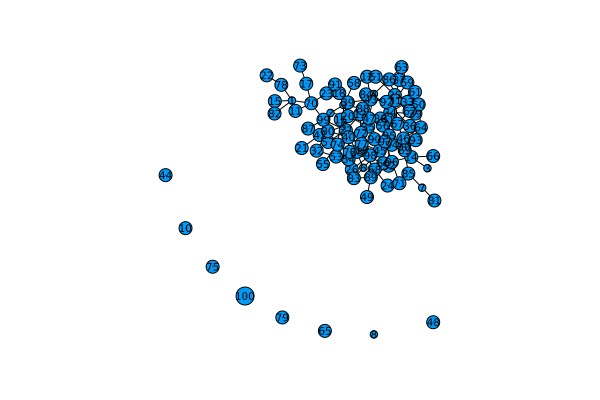

In [4]:
NV = 100 # number of graph vertices
k = 3 # average degree

# generate a random graph with NV vertices and NE edges
#G = random_regular_graph(NV, ceil(Int,k))

#genrate an Erdos-Renyi random graph with average connectivity k
G = erdos_renyi(NV, k/NV)

# generate a random tree
#G = uniform_tree(NV)

# generate a Watts-Strogatz small world random graph with average connectivity k
#G = watts_strogatz(NV, ceil(Int,k), 0.1, remove_edges = true)

# Graph plotting
display(graphplot(G, names=vertices(G), edgecolor=:black,curves=false, nodeshape=:circle, markersize =.15))

## - SIRS: model simulation

### System parameter definition and simulation

sources: [33, 86]


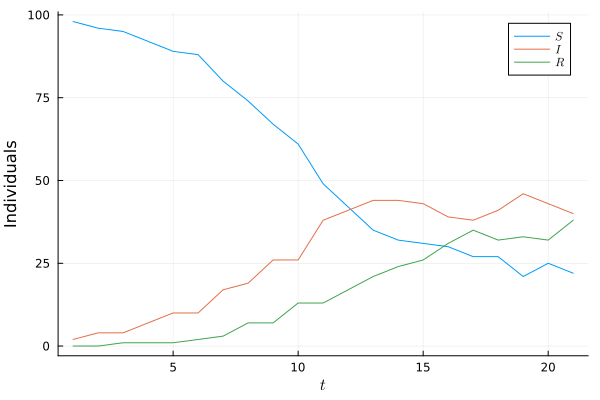

In [5]:
# define the constants
T::Int = 20 # total time
fₚ::Float64 = 0.0 # false-positive rate
fₙ::Float64 = 0.0 # false-negative rate
γ::Float64 = 1/NV # Patient zero probability
λ₀::Float64 = 0.4 # Infection rate
r₀::Float64 = 0.15 # Recovery rate
σ₀::Float64 = 0.15 # Immunity rate
ε_autoinf::Float64 = 1e-10 # Self-infection rate

# define the observation probability
function obsprob(Ob::Float64, x::Float64)
    if Ob == -1.0
        return 1.0
    else
        return Float64(Ob == x)
    end
end

# constant infection probability
λ = zeros(NV, NV, T+1)
for e in edges(G)
    λ[src(e), dst(e), :] = ones(T+1) * λ₀
    λ[dst(e), src(e), :] = ones(T+1) * λ₀
end

# define de epidemic model
infectionmodel = SIRS(ε_autoinf, r₀, σ₀, NV, T)
model = EpidemicModel(infectionmodel, G, T, log.(1 .- λ))

# epidemic simulation
config = sim_epidemics(model, γ=γ)
inf_tuples, invperm_sort, perm_sort = sort_by_infection_time(config, T, NV)

isource = findall(x->x==1.0, config[:,1])
println("sources: $(isource)")

# infected individuals over time
nrI = dropdims(sum(map(x->Float64(x==1.0),config), dims = 1), dims = 1)
nrS = dropdims(sum(map(x->Float64(x==0.0),config), dims = 1), dims = 1)
nrR = dropdims(sum(map(x->Float64(x==2.0),config), dims = 1), dims = 1)
display(plot([nrS nrI nrR], xlabel = L"t", ylabel = "Individuals", label = [L"S" L"I" L"R"]))

### Generation of observations

In [7]:
const Nobs::Int = ceil(NV*.75) # number of observations

# generate observations
obsmat = ones(nv(G), T+1) * (-1.0)
obslist = []
for (iₗ, τₗ) in sample(collect(zip(1:NV,ones(Int, NV)*ceil(Int, T*.51))), Nobs, replace = false) 
    obsmat[iₗ, τₗ] = config[iₗ, τₗ]
    push!(obslist, (iₗ, τₗ-1))
end
    
# insert the observations into the model structure
model.obsmat .= obsmat;

In [8]:
println(obslist)

Any[(26, 10), (56, 10), (55, 10), (21, 10), (5, 10), (68, 10), (15, 10), (46, 10), (7, 10), (92, 10), (89, 10), (48, 10), (75, 10), (66, 10), (58, 10), (85, 10), (83, 10), (84, 10), (78, 10), (20, 10), (1, 10), (9, 10), (16, 10), (52, 10), (65, 10), (45, 10), (19, 10), (29, 10), (43, 10), (69, 10), (87, 10), (90, 10), (40, 10), (34, 10), (80, 10), (8, 10), (4, 10), (98, 10), (47, 10), (60, 10), (37, 10), (94, 10), (11, 10), (39, 10), (88, 10), (70, 10), (99, 10), (81, 10), (71, 10), (74, 10), (77, 10), (30, 10), (51, 10), (28, 10), (25, 10), (62, 10), (100, 10), (38, 10), (35, 10), (86, 10), (57, 10), (27, 10), (6, 10), (97, 10), (44, 10), (82, 10), (64, 10), (54, 10), (23, 10), (96, 10), (32, 10), (42, 10), (17, 10), (93, 10), (10, 10)]


## Inference SCDC -- autoinfection, $\mu$ cutoff

In [9]:
# computational constants
epsconv::Float64 = 5e-15 # convergence threshold
maxiter::Int = 5e2 # max number of iterations
damp::Float64 = 0.0 # damping factor
μ_cutoff::Float64 = -1

# callback function
function report(nodes,iter,ε) 
    println("i = ", iter,  " ε = ", ε)
end

nodes = run_SCDC(model, obsprob, γ, maxiter, epsconv, damp, μ_cutoff = μ_cutoff, callback = report)

marg_prob_sorted = zeros(NV, T+1, 3)
for inode in nodes
#    marg_prob_sorted[inode.i,:,:] .= inode.marg.m'
    marg_prob_sorted[invperm_sort[inode.i],:,:] .= inode.marg.m'
end
 #marg_prob_sorted = marg_prob_sorted[perm_sort,:,:];

i = 1 ε = 1.1496306065805755
i = 2 ε = 1.8972286682122583
i = 3 ε = 1.7964571748065261
i = 4 ε = 1.5152587649060438
i = 5 ε = 0.6574356937536379
i = 6 ε = 0.5188699359188357
i = 7 ε = 0.7342904879147527
i = 8 ε = 0.25806066160094243
i = 9 ε = 0.10207304191056676
i = 10 ε = 0.08931679827334671
i = 11 ε = 0.1307474710114851
i = 12 ε = 0.014681982270251748
i = 13 ε = 0.021820669025209072
i = 14 ε = 0.009774686712857084
i = 15 ε = 0.007185447435851033
i = 16 ε = 0.004277087471324603
i = 17 ε = 0.0012171326919557801
i = 18 ε = 0.0006170599806379906
i = 19 ε = 0.0003851749318868336
i = 20 ε = 0.00044670559126869236
i = 21 ε = 6.652942333462697e-5
i = 22 ε = 7.050470734271119e-5
i = 23 ε = 2.537612716624338e-5
i = 24 ε = 1.658718232433465e-5
i = 25 ε = 1.1961838646046274e-5
i = 26 ε = 3.263661135788354e-6
i = 27 ε = 2.777260215580668e-6
i = 28 ε = 9.345125285831202e-7
i = 29 ε = 1.0553537378443778e-6
i = 30 ε = 1.6415642212219694e-7
i = 31 ε = 2.096370740334308e-7
i = 32 ε = 1.051450850830804

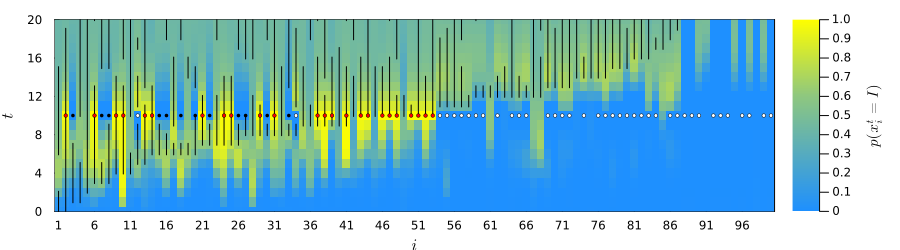

In [10]:
resize_factor = 1.0

cg = cgrad([:dodgerblue, :yellow], 0.6)

plI = heatmap(1:NV, 0:T, marg_prob_sorted[:,:,2]', c=cg, xlabel=L"i", ylabel=L"t", colorbar_title=L"p(x_i^t=I)", yrange=(0,T), xticks=1:5:NV, framestyle = :box)

for (i, inf_time_list) in inf_tuples
    for inf_time in inf_time_list
        plot!(plI, [invperm_sort[i],invperm_sort[i]], [inf_time[1]-0.1,inf_time[2]+0.1], c=:black, label="", lw=1)
    end
end

cols = [:white, :red, :black]
for (i,t) in obslist
    scatter!(plI, [invperm_sort[i]], [t], ms=2, msc=:black, c=cols[ceil(Int,config[i,t+1])+1], label="")
end

plot!(plI, yticks=0:(T÷5):T, widen=false, margin=3Plots.mm, size=(900,250).*resize_factor)

display(plI)

## Inference -- no autoinfection, no $\mu$ cutoff

In [12]:
# computational constants
μ_cutoff::Float64 = -Inf
ε_autoinf::Float64 = 0.0

model.Disease.εᵢᵗ .*= ε_autoinf 

# callback function
function report(nodes,iter,ε) 
    println("i = ", iter,  " ε = ", ε)
end

nodes = run_SCDC(model, obsprob, γ, maxiter, epsconv, damp, μ_cutoff = μ_cutoff, callback = report)

marg_prob_sorted = zeros(NV, T+1, 3)
for inode in nodes
    marg_prob_sorted[invperm_sort[inode.i],:,:] .= inode.marg.m'
end

i = 1 ε = 429.1591027341102
i = 2 ε = 168.46204900416708
i = 3 ε = 165.27307691055324
i = 4 ε = 23.247003465549327
i = 5 ε = 36.23928367794841
i = 6 ε = 3.1033635573136173
i = 7 ε = 5.329850578742995
i = 8 ε = 1.381045729276785
i = 9 ε = 0.45520444541704563
i = 10 ε = 0.25059582040953643
i = 11 ε = 0.11785687293906033
i = 12 ε = 0.044976690696307386
i = 13 ε = 0.0157232790394346
i = 14 ε = 0.015206554008038609
i = 15 ε = 0.008245683057104713
i = 16 ε = 0.003728041242716529
i = 17 ε = 0.000587547361125651
i = 18 ε = 0.0005251136992210359
i = 19 ε = 0.000245760916401494
i = 20 ε = 4.924236706660423e-5
i = 21 ε = 2.8901442803430655e-5
i = 22 ε = 3.342028843889011e-5
i = 23 ε = 1.3583320296106649e-5
i = 24 ε = 2.6541660531620437e-6
i = 25 ε = 2.9049699576955135e-6
i = 26 ε = 1.1596688727077975e-6
i = 27 ε = 4.088841407678956e-7
i = 28 ε = 1.8086000230788102e-7
i = 29 ε = 1.4286006688735142e-7
i = 30 ε = 6.978126121381933e-8
i = 31 ε = 1.5860859292615714e-8
i = 32 ε = 1.575568542300232e-8
i

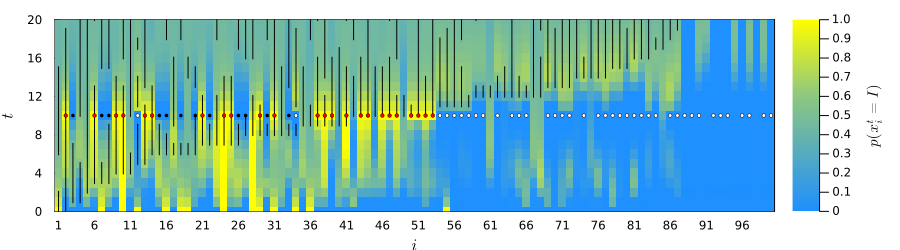

In [13]:
resize_factor = 1.0

cg = cgrad([:dodgerblue, :yellow], 0.6)

plI = heatmap(1:NV, 0:T, marg_prob_sorted[:,:,2]', c=cg, xlabel=L"i", ylabel=L"t", colorbar_title=L"p(x_i^t=I)", yrange=(0,T), xticks=1:5:NV, framestyle = :box)

for (i, inf_time_list) in inf_tuples
    for inf_time in inf_time_list
        plot!(plI, [invperm_sort[i],invperm_sort[i]], [inf_time[1]-0.1,inf_time[2]+0.1], c=:black, label="", lw=1)
    end
end

cols = [:white, :red, :black]
for (i,t) in obslist
    scatter!(plI, [invperm_sort[i]], [t], ms=2, msc=:black, c=cols[ceil(Int,config[i,t+1])+1], label="")
end

plot!(plI, yticks=0:(T÷5):T, widen=false, margin=3Plots.mm, size=(900,250).*resize_factor)

display(plI)